In [1]:
!pip uninstall -y numpy opencv-python opencv-contrib-python
!pip install numpy==1.26.4
!pip install opencv-contrib-python==4.8.1.78 pandas


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: opencv-contrib-python 4.8.1.78
Uninstalling opencv-contrib-python-4.8.1.78:
  Successfully uninstalled opencv-contrib-python-4.8.1.78
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is

  Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached opencv_contrib_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.8 MB)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cv2, os, numpy as np, pandas as pd
from datetime import datetime
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow


In [4]:
!wget -q -O haarcascade_frontalface_default.xml \
https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [6]:
# 5️⃣ Webcam Capture Function (Attendance Only)
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const video = document.createElement('video');
          const stream = await navigator.mediaDevices.getUserMedia({video:true});
          document.body.appendChild(video);
          video.srcObject = stream;
          await video.play();
          await new Promise(resolve => setTimeout(resolve, 2000));
          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video,0,0);
          stream.getTracks()[0].stop();
          video.remove();
          return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto(''' + str(quality) + ''');
    ''')
    display(js)
    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


In [7]:
# 6️⃣ Load Dataset From Google Drive
DATASET_PATH = "/content/drive/MyDrive/dataset"

faces = []
labels = []
label_map = {}
label = 0

for student_id in os.listdir(DATASET_PATH):
    student_path = os.path.join(DATASET_PATH, student_id)
    if not os.path.isdir(student_path):
        continue

    label_map[label] = student_id

    for img_name in os.listdir(student_path):
        img_path = os.path.join(student_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (200, 200))
        faces.append(img)
        labels.append(label)

    label += 1

print("✅ Dataset loaded successfully")
print("Total students:", len(label_map))


✅ Dataset loaded successfully
Total students: 39


In [8]:
#7️⃣ Train LBPH Model
recognizer = cv2.face.LBPHFaceRecognizer_create()
recognizer.train(faces, np.array(labels))
print("✅ LBPH model trained successfully")


✅ LBPH model trained successfully


In [9]:
# 8️⃣ Attendance CSV Functions
ATTENDANCE_FILE = "/content/attendance.csv"

def mark_attendance(student_id):
    date_now = datetime.now().strftime("%Y-%m-%d")
    time_now = datetime.now().strftime("%H:%M:%S")

    if os.path.exists(ATTENDANCE_FILE):
        df = pd.read_csv(ATTENDANCE_FILE)
    else:
        df = pd.DataFrame(columns=["Student_ID", "Date", "Time"])

    if not ((df["Student_ID"] == student_id) & (df["Date"] == date_now)).any():
        df.loc[len(df)] = [student_id, date_now, time_now]
        df.to_csv(ATTENDANCE_FILE, index=False)
        print(f"✅ Attendance marked: {student_id}")
    else:
        print(f"⚠ Already marked: {student_id}")


📷 Capturing image for attendance...


<IPython.core.display.Javascript object>

⚠ Already marked: 22-49861-3


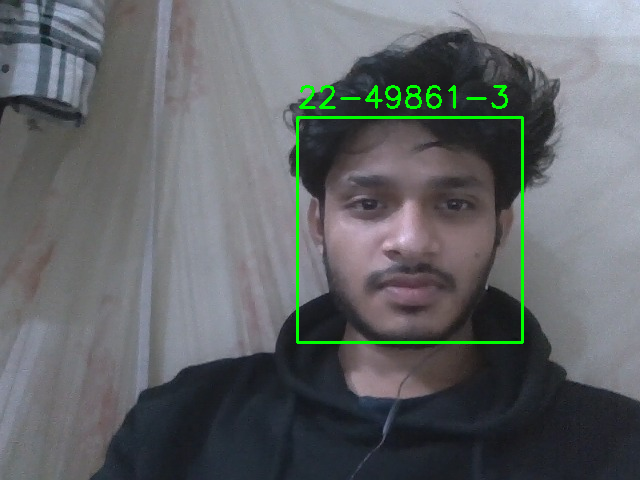

In [50]:
# 9️⃣ Take Attendance (Live Camera)
confidence_threshold = 80

print("📷 Capturing image for attendance...")
take_photo("test.jpg")

img = cv2.imread("test.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces_detected = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces_detected:
    face = cv2.resize(gray[y:y+h, x:x+w], (200,200))
    label, confidence = recognizer.predict(face)

    if confidence < confidence_threshold:
        student_id = label_map[label]
        mark_attendance(student_id)
    else:
        student_id = "Unknown"

    cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)
    cv2.putText(img, student_id, (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

cv2_imshow(img)


In [40]:
# 🔟 View Attendance CSV
if os.path.exists(ATTENDANCE_FILE):
    df = pd.read_csv(ATTENDANCE_FILE)
    display(df)
else:
    print("No attendance records found.")


,Student_ID,Date,Time
0,22-49861-3,2026-01-04,19:45:18
1,22-49858-3,2026-01-04,19:49:27
